# DATA PROJECT: INCOME TAXES AND WAGES

#### Imports and set magics:

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject

#### **Introduction:** In this project, I conduct a very simple data analysis in which I investigate the relationship between the Danish wage sum (loosly speaking the sum of all Danish wages before taxes), and the government revenue from personal income taxes. The hypothesis is that there is a positive correlation between the two variables, as it is fair to assume that a large part of the personal income tax revenue stems from wages ("A-indkomst"). Income from sources like pensions and unemployment benefits is of course also taxed, but is disregarded in this case.

## 1. Read and clean data

#### The data is downloaded from Statistics Denmark and is read and cleaned in ```dataproject.py```. 

#### Note that I remove data from 1947-2007 and 2022 for the taxes, as data for these years is not included for the wages.

#### **Clean the tax data:**

In [343]:
taxes = dataproject.clean_taxes()
taxes

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,435.86572,435.208167,427.39679,434.782952,447.703423,496.126697,535.059877,529.160244,517.996701,537.574707,551.458739,572.840968,602.67136,640.806158


#### **Clean the wage sum data:**

In [344]:
wage_sum = dataproject.clean_wages()
wage_sum

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,934.155,930.387,938.04,949.468,961.264,973.053,998.311,1027.381,1063.554,1099.372,1138.684,1168.433,1182.66,1265.106


#### **Convert the data from wide to long format:**

In [345]:
wage_sum = wage_sum.reset_index().melt(value_vars=wage_sum.columns[0:], var_name='year', value_name='wage_sum')
wage_sum

,year,wage_sum
0,2008,934.155
1,2009,930.387
2,2010,938.040
3,2011,949.468
4,2012,961.264
5,2013,973.053
6,2014,998.311
7,2015,1027.381
8,2016,1063.554
9,2017,1099.372


In [346]:
taxes = taxes.reset_index().melt(value_vars=taxes.columns[0:], var_name='year', value_name='personal_income_taxes')
taxes

,year,personal_income_taxes
0,2008,435.865720
1,2009,435.208167
2,2010,427.396790
3,2011,434.782952
4,2012,447.703423
5,2013,496.126697
6,2014,535.059877
7,2015,529.160244
8,2016,517.996701
9,2017,537.574707


#### **Finally, merge the two datasets:**

In [347]:
merged = pd.merge(wage_sum, taxes, on=['year'], how='outer')
merged

,year,wage_sum,personal_income_taxes
0,2008,934.155,435.865720
1,2009,930.387,435.208167
2,2010,938.040,427.396790
3,2011,949.468,434.782952
4,2012,961.264,447.703423
5,2013,973.053,496.126697
6,2014,998.311,535.059877
7,2015,1027.381,529.160244
8,2016,1063.554,517.996701
9,2017,1099.372,537.574707


## 2. Explore each data set

#### **Add two variables describing the yearly change in the wage sum and the tax revenue respectively:**

In [348]:
merged["taxes_change"] = merged["personal_income_taxes"].diff() # change in taxes
merged["wage_sum_change"] = merged["wage_sum"].diff() # change in wages
merged

,year,wage_sum,personal_income_taxes,taxes_change,wage_sum_change
0,2008,934.155,435.865720,NaN,NaN
1,2009,930.387,435.208167,-0.657553,-3.768
2,2010,938.040,427.396790,-7.811377,7.653
3,2011,949.468,434.782952,7.386162,11.428
4,2012,961.264,447.703423,12.920471,11.796
5,2013,973.053,496.126697,48.423274,11.789
6,2014,998.311,535.059877,38.933180,25.258
7,2015,1027.381,529.160244,-5.899633,29.070
8,2016,1063.554,517.996701,-11.163543,36.173
9,2017,1099.372,537.574707,19.578006,35.818


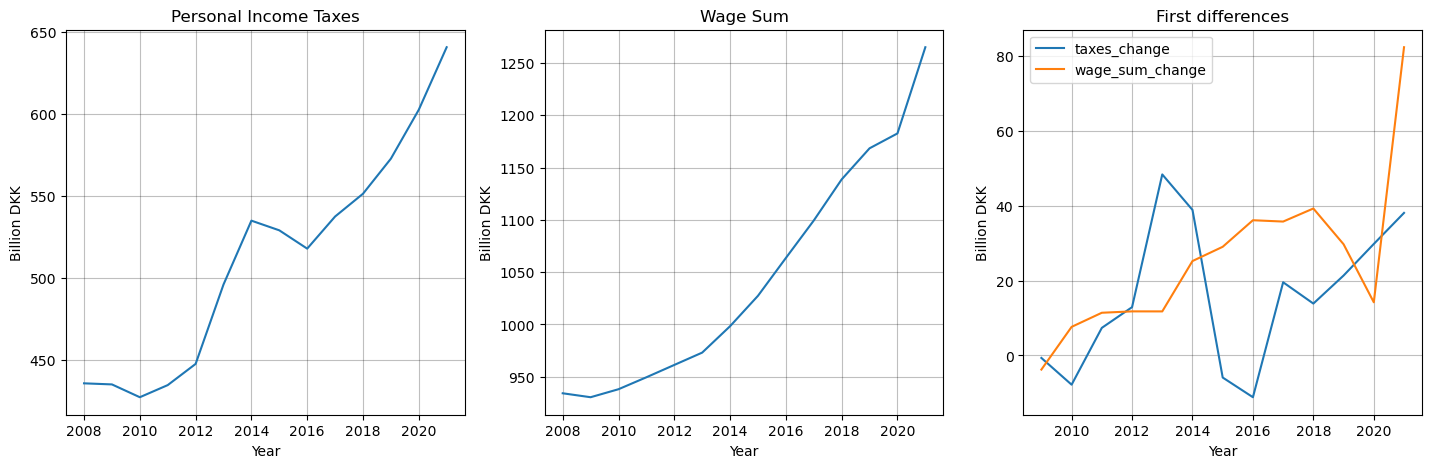

In [356]:
# Predefine options for plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 10})

# Create a subplot with three plots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17.5, 5))

# Plot personal income taxes
merged.plot(x='year', y='personal_income_taxes', legend=False, ax=ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Billion DKK')
ax1.set_title('Personal Income Taxes')

# Plot wage sum
merged.plot(x='year', y='wage_sum', legend=False, ax=ax2)
ax2.set_xlabel('Year')
ax2.set_ylabel('Billion DKK')
ax2.set_title('Wage Sum')

# Plot first differences
merged.plot(x='year', y='wage_sum_change', ax=ax3)
merged.plot(x='year', y='taxes_change',  ax=ax3)
ax3.set_xlabel('Year')
ax3.set_ylabel('Billion DKK')
ax3.set_title('First differences')

# Display the plot
plt.show()

In [2]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

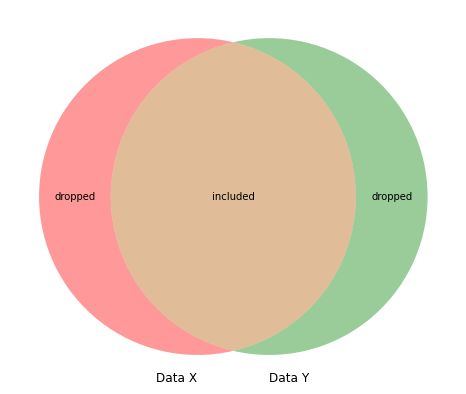

In [3]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.